## GRIDSEARCH CV : Optimisation des hyperparamètres et sauvegarde des performances des modèles 

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Chemins
base_folder_black = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_black'
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'
save_folder = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5'
csv_path = os.path.join(save_folder, 'model_performances.csv')

# Paramètres
img_size = 255
num_classes = 3
loss_functions = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [8, 32]
epochs_list = [5, 20]
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
# Charger ou créer le DataFrame des performances
if os.path.exists(csv_path):
    df_performances = pd.read_csv(csv_path)
else:
    df_performances = pd.DataFrame(columns=['model_type', 'batch_size', 'optimizer', 'learning_rate', 'epochs', 'accuracy', 'loss', 'val_accuracy', 'val_loss'])

# Fonction pour créer un modèle Conv2D
def create_conv2d_model(input_shape, optimizer):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Fonction pour appliquer Grid Search et sauvegarder le meilleur modèle
def grid_search_and_save_best_model(train_generator, val_generator, model_type='RGB'):
    best_accuracy = 0
    best_model = None
    best_params = {}
    csv_path="C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Projet_5/model_performances_cnn.csv"
    for batch_size in batch_sizes:
        for optimizer_name in loss_functions:
            for learning_rate in learning_rates:
                for epochs in epochs_list:
                                        # Charger ou créer le DataFrame des performances
                    # Charger ou créer le DataFrame des performances
                    if os.path.exists(csv_path):
                        df_performances = pd.read_csv(csv_path)
                        
                        # Vérifier si 'model_type' existe dans le DataFrame, sinon l'ajouter
                        if 'model_type' not in df_performances.columns:
                            df_performances['model_type'] = None
                    else:
                        df_performances = pd.DataFrame(columns=['model_type', 'batch_size', 'optimizer', 'learning_rate', 'epochs', 'accuracy', 'loss', 'val_accuracy', 'val_loss'])
                    # Vérifier si la combinaison existe déjà
                    existing_row = df_performances[
                        (df_performances['model_type'] == model_type) &
                        (df_performances['batch_size'] == batch_size) &
                        (df_performances['optimizer'] == optimizer_name) &
                        (df_performances['learning_rate'] == learning_rate) &
                        (df_performances['epochs'] == epochs)
                    ]
                    if not existing_row.empty:
                        print(f"Skipping: {model_type}, batch_size={batch_size}, optimizer={optimizer_name}, learning_rate={learning_rate}, epochs={epochs}")
                        continue

                    print(f"Testing: {model_type}, batch_size={batch_size}, optimizer={optimizer_name}, learning_rate={learning_rate}, epochs={epochs}")

                    # Configurer l'input_shape
                    input_shape = (img_size, img_size, 1) if model_type == 'Black and White' else (img_size, img_size, 3)

                    # Configurer l'optimiseur avec le taux d'apprentissage
                    if optimizer_name == 'adam':
                        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                    elif optimizer_name == 'rmsprop':
                        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
                    elif optimizer_name == 'sgd':
                        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

                    # Créer le modèle
                    model = create_conv2d_model(input_shape=input_shape, optimizer=optimizer)

                    # Early Stopping
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                    # Calcul des class weights
                    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
                    class_weights_dict = dict(enumerate(class_weights))

                    # Entraîner le modèle
                    history = model.fit(
                        train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        batch_size=batch_size,
                        class_weight=class_weights_dict,
                        callbacks=[early_stopping],
                        verbose=1
                    )

                    # Récupérer les performances
                    accuracy = max(history.history['accuracy'])
                    loss = min(history.history['loss'])
                    val_accuracy = max(history.history['val_accuracy'])
                    val_loss = min(history.history['val_loss'])

                    # Enregistrer les performances dans le DataFrame
                    df_performances.loc[len(df_performances)] = {
                        'model_type': model_type,
                        'batch_size': batch_size,
                        'optimizer': optimizer_name,
                        'learning_rate': learning_rate,
                        'epochs': epochs,
                        'accuracy': accuracy,
                        'loss': loss,
                        'val_accuracy': val_accuracy,
                        'val_loss': val_loss
                    }

                    # Sauvegarder les performances dans le fichier CSV
                    df_performances.to_csv(csv_path, index=False)

                    # Sauvegarder le meilleur modèle
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_model = model
                        best_params = {
                            'batch_size': batch_size,
                            'optimizer': optimizer_name,
                            'learning_rate': learning_rate,
                            'epochs': epochs
                        }
                        print(f"New best model found with accuracy {best_accuracy:.4f}")

    best_model.save(os.path.join(save_folder, f'best_model_{model_type}.keras'))
    print(f"Best model saved for {model_type} with accuracy {best_accuracy:.4f} and parameters: {best_params}")

    return best_model, best_params



# Préparer les générateurs d'images
def prepare_data_generators(batch_size, is_black_and_white=True):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    color_mode = 'grayscale' if is_black_and_white else 'rgb'
    
    train_generator = datagen.flow_from_directory(
        base_folder_black if is_black_and_white else base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        base_folder_black if is_black_and_white else base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, val_generator

# Entraîner et tester les modèles pour les images RGB
train_generator_rgb, val_generator_rgb = prepare_data_generators(batch_size=batch_sizes[0], is_black_and_white=False)
print("Running Grid Search for RGB Images...")
best_rgb_model, best_rgb_params = grid_search_and_save_best_model(train_generator_rgb, val_generator_rgb, model_type='RGB')


Found 4712 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.
Running Grid Search for RGB Images...
Testing: RGB, batch_size=8, optimizer=adam, learning_rate=0.01, epochs=5


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.3765 - loss: 1.4251 - val_accuracy: 0.2581 - val_loss: 1.1106
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.3102 - loss: 1.0998 - val_accuracy: 0.2581 - val_loss: 1.1118
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.3377 - loss: 1.0970 - val_accuracy: 0.3141 - val_loss: 1.1013
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.3071 - loss: 1.1031 - val_accuracy: 0.3141 - val_loss: 1.0939
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.3052 - loss: 1.1051 - val_accuracy: 0.4278 - val_loss: 1.0974
New best model found with accuracy 0.4278
Testing: RGB, batch_size=8, optimizer=adam, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3363 - loss: 1.2702 - val_accuracy: 0.2581 - val_loss: 1.1082
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3022 - loss: 1.1039 - val_accuracy: 0.4278 - val_loss: 1.0894
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3923 - loss: 1.0974 - val_accuracy: 0.2581 - val_loss: 1.0986
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3327 - loss: 1.1015 - val_accuracy: 0.3141 - val_loss: 1.0948
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3452 - loss: 1.0983 - val_accuracy: 0.4278 - val_loss: 1.0918
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3716 - loss: 1.0982 - val_accuracy: 0.3141 - val_loss: 1.0981
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3146 - loss: 1.0987 - val_accuracy: 0.4278 - val_loss: 1.0945
Testing: RGB, batch_size=8, optimizer=adam, learning_rate=0.001, epochs=5
Epoch 1/5


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3888 - loss: 1.0691 - val_accuracy: 0.5238 - val_loss: 0.9838
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6195 - loss: 0.8514 - val_accuracy: 0.6749 - val_loss: 0.7500
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.7399 - loss: 0.6339 - val_accuracy: 0.7436 - val_loss: 0.6156
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.8275 - loss: 0.4227 - val_accuracy: 0.7326 - val_loss: 0.6804
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8848 - loss: 0.3181 - val_accuracy: 0.6842 - val_loss: 1.0343
New best model found with accuracy 0.7436
Testing: RGB, batch_size=8, optimizer=adam, learning_rate=0.001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3973 - loss: 1.0683 - val_accuracy: 0.5484 - val_loss: 0.9633
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6599 - loss: 0.8092 - val_accuracy: 0.6927 - val_loss: 0.7313
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.7625 - loss: 0.5940 - val_accuracy: 0.7233 - val_loss: 0.7014
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.8452 - loss: 0.4016 - val_accuracy: 0.7640 - val_loss: 0.6270
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8869 - loss: 0.2946 - val_accuracy: 0.7470 - val_loss: 0.6863
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9223 - loss: 0.2108 - val_accuracy: 0.7360 - val_loss: 0.7056
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9404 - loss: 0.1627 - val_accuracy: 0.7581 - val_loss: 0.7431
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9615 - loss: 0.1117 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4430 - loss: 1.0307 - val_accuracy: 0.5985 - val_loss: 0.8851
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.6319 - loss: 0.8313 - val_accuracy: 0.6647 - val_loss: 0.7593
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7209 - loss: 0.6935 - val_accuracy: 0.7037 - val_loss: 0.6838
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.7845 - loss: 0.5667 - val_accuracy: 0.7547 - val_loss: 0.6046
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8162 - loss: 0.4666 - val_accuracy: 0.7343 - val_loss: 0.6586
Testing: RGB, batch_size=8, optimizer=adam, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4289 - loss: 1.0259 - val_accuracy: 0.5195 - val_loss: 0.9733
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6485 - loss: 0.8102 - val_accuracy: 0.6851 - val_loss: 0.7496
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.7214 - loss: 0.6776 - val_accuracy: 0.7309 - val_loss: 0.6596
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7867 - loss: 0.5582 - val_accuracy: 0.7165 - val_loss: 0.6630
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8238 - loss: 0.4740 - val_accuracy: 0.7555 - val_loss: 0.6426
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8452 - loss: 0.4061 - val_accuracy: 0.7793 - val_loss: 0.5948
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8798 - loss: 0.3216 - val_accuracy: 0.7835 - val_loss: 0.5995
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9082 - loss: 0.2647 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3430 - loss: 25.7262 - val_accuracy: 0.2581 - val_loss: 1.1158
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3250 - loss: 1.1004 - val_accuracy: 0.3141 - val_loss: 1.1099
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3097 - loss: 1.0999 - val_accuracy: 0.2581 - val_loss: 1.1090
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3074 - loss: 1.0976 - val_accuracy: 0.2581 - val_loss: 1.1085
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3076 - loss: 1.0999 - val_accuracy: 0.3141 - val_loss: 1.1042
Testing: RGB, batch_size=8, optimizer=rmsprop, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3239 - loss: 8.5824 - val_accuracy: 0.3141 - val_loss: 1.0918
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3251 - loss: 1.1014 - val_accuracy: 0.4278 - val_loss: 1.0957
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3853 - loss: 1.0956 - val_accuracy: 0.2581 - val_loss: 1.1007
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3171 - loss: 1.1011 - val_accuracy: 0.2581 - val_loss: 1.0978
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3005 - loss: 1.1027 - val_accuracy: 0.4278 - val_loss: 1.0879
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3788 - loss: 1.1014 - val_accuracy: 0.3141 - val_loss: 1.0925
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3723 - loss: 1.0911 - val_accuracy: 0.2581 - val_loss: 1.1023
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3272 - loss: 1.0978 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4530 - loss: 1.0460 - val_accuracy: 0.4618 - val_loss: 1.0661
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6723 - loss: 0.7889 - val_accuracy: 0.7020 - val_loss: 0.7201
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7933 - loss: 0.5367 - val_accuracy: 0.7292 - val_loss: 0.7429
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.8585 - loss: 0.3985 - val_accuracy: 0.7742 - val_loss: 0.5807
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.8895 - loss: 0.3050 - val_accuracy: 0.7615 - val_loss: 1.0262
Testing: RGB, batch_size=8, optimizer=rmsprop, learning_rate=0.001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4155 - loss: 1.0640 - val_accuracy: 0.4397 - val_loss: 1.1080
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6480 - loss: 0.8078 - val_accuracy: 0.6477 - val_loss: 0.8238
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7501 - loss: 0.6055 - val_accuracy: 0.5849 - val_loss: 1.2149
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.8307 - loss: 0.4321 - val_accuracy: 0.7487 - val_loss: 0.7042
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8913 - loss: 0.3153 - val_accuracy: 0.7385 - val_loss: 0.7947
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9104 - loss: 0.2469 - val_accuracy: 0.6503 - val_loss: 1.4219
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9210 - loss: 0.2185 - val_accuracy: 0.7207 - val_loss: 1.0914
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9355 - loss: 0.2206 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4014 - loss: 1.0466 - val_accuracy: 0.6154 - val_loss: 0.9128
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6274 - loss: 0.8454 - val_accuracy: 0.6435 - val_loss: 0.7854
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6855 - loss: 0.7356 - val_accuracy: 0.5730 - val_loss: 0.9319
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7184 - loss: 0.6728 - val_accuracy: 0.7267 - val_loss: 0.6657
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7581 - loss: 0.5957 - val_accuracy: 0.7368 - val_loss: 0.6148
Testing: RGB, batch_size=8, optimizer=rmsprop, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4157 - loss: 1.0536 - val_accuracy: 0.5883 - val_loss: 0.9249
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6180 - loss: 0.8495 - val_accuracy: 0.5671 - val_loss: 0.9463
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6670 - loss: 0.7701 - val_accuracy: 0.6698 - val_loss: 0.7866
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7350 - loss: 0.6415 - val_accuracy: 0.6935 - val_loss: 0.7324
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7575 - loss: 0.5866 - val_accuracy: 0.6952 - val_loss: 0.7392
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7925 - loss: 0.5087 - val_accuracy: 0.7581 - val_loss: 0.6532
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8373 - loss: 0.4488 - val_accuracy: 0.6885 - val_loss: 0.8573
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.8622 - loss: 0.3568 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3608 - loss: 1.0861 - val_accuracy: 0.4643 - val_loss: 1.0274
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.4813 - loss: 1.0105 - val_accuracy: 0.5798 - val_loss: 0.9481
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5849 - loss: 0.9138 - val_accuracy: 0.6163 - val_loss: 0.9004
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6575 - loss: 0.8162 - val_accuracy: 0.6553 - val_loss: 0.7960
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7041 - loss: 0.7380 - val_accuracy: 0.6647 - val_loss: 0.7754
Testing: RGB, batch_size=8, optimizer=sgd, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3776 - loss: 1.0759 - val_accuracy: 0.5526 - val_loss: 1.0099
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5139 - loss: 0.9863 - val_accuracy: 0.5662 - val_loss: 0.9326
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6157 - loss: 0.8691 - val_accuracy: 0.6307 - val_loss: 0.8269
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6644 - loss: 0.7875 - val_accuracy: 0.6655 - val_loss: 0.7713
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6993 - loss: 0.7246 - val_accuracy: 0.6944 - val_loss: 0.7585
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7519 - loss: 0.6259 - val_accuracy: 0.6842 - val_loss: 0.6968
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.7823 - loss: 0.5424 - val_accuracy: 0.7284 - val_loss: 0.6558
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8236 - loss: 0.4703 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3397 - loss: 1.0948 - val_accuracy: 0.3998 - val_loss: 1.0949
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3898 - loss: 1.0887 - val_accuracy: 0.3752 - val_loss: 1.0882
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.4309 - loss: 1.0816 - val_accuracy: 0.5068 - val_loss: 1.0807
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.4717 - loss: 1.0684 - val_accuracy: 0.5102 - val_loss: 1.0723
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.4955 - loss: 1.0480 - val_accuracy: 0.5569 - val_loss: 1.0317
Testing: RGB, batch_size=8, optimizer=sgd, learning_rate=0.001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3527 - loss: 1.0972 - val_accuracy: 0.4202 - val_loss: 1.0960
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.3727 - loss: 1.0892 - val_accuracy: 0.4686 - val_loss: 1.0917
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.4060 - loss: 1.0873 - val_accuracy: 0.4958 - val_loss: 1.0781
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.4254 - loss: 1.0782 - val_accuracy: 0.5739 - val_loss: 1.0736
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4812 - loss: 1.0692 - val_accuracy: 0.5857 - val_loss: 1.0454
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5309 - loss: 1.0420 - val_accuracy: 0.5934 - val_loss: 1.0315
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5380 - loss: 1.0148 - val_accuracy: 0.5857 - val_loss: 0.9797
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.5716 - loss: 0.9646 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.2914 - loss: 1.0984 - val_accuracy: 0.2581 - val_loss: 1.1055
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3243 - loss: 1.1001 - val_accuracy: 0.2589 - val_loss: 1.1032
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3024 - loss: 1.0981 - val_accuracy: 0.2623 - val_loss: 1.1017
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3239 - loss: 1.0990 - val_accuracy: 0.2691 - val_loss: 1.1004
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3087 - loss: 1.0927 - val_accuracy: 0.3048 - val_loss: 1.0991
Testing: RGB, batch_size=8, optimizer=sgd, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3227 - loss: 1.1009 - val_accuracy: 0.3277 - val_loss: 1.0967
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3406 - loss: 1.1068 - val_accuracy: 0.3548 - val_loss: 1.0936
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3439 - loss: 1.0934 - val_accuracy: 0.3939 - val_loss: 1.0914
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3633 - loss: 1.0977 - val_accuracy: 0.4092 - val_loss: 1.0895
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3520 - loss: 1.0925 - val_accuracy: 0.4372 - val_loss: 1.0884
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3589 - loss: 1.0934 - val_accuracy: 0.4890 - val_loss: 1.0865
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3822 - loss: 1.0897 - val_accuracy: 0.5059 - val_loss: 1.0851
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3780 - loss: 1.0854 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3361 - loss: 2.8974 - val_accuracy: 0.2581 - val_loss: 1.1048
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3363 - loss: 1.0968 - val_accuracy: 0.2581 - val_loss: 1.1060
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3322 - loss: 1.0985 - val_accuracy: 0.3141 - val_loss: 1.1020
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3785 - loss: 1.0939 - val_accuracy: 0.2581 - val_loss: 1.1046
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3330 - loss: 1.1000 - val_accuracy: 0.2581 - val_loss: 1.1041
Testing: RGB, batch_size=32, optimizer=adam, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3230 - loss: 1.4068 - val_accuracy: 0.4278 - val_loss: 1.0892
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3721 - loss: 1.0959 - val_accuracy: 0.2581 - val_loss: 1.1180
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3046 - loss: 1.1003 - val_accuracy: 0.3141 - val_loss: 1.1143
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3293 - loss: 1.1010 - val_accuracy: 0.3141 - val_loss: 1.1123
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3179 - loss: 1.0977 - val_accuracy: 0.2581 - val_loss: 1.0999
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3219 - loss: 1.0959 - val_accuracy: 0.2581 - val_loss: 1.1082
Testing: RGB, batch_size=32, optimizer=adam, learning_rate=0.001, epochs=5
Epoch 1/5


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3838 - loss: 1.0692 - val_accuracy: 0.5357 - val_loss: 1.0019
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5930 - loss: 0.8735 - val_accuracy: 0.6715 - val_loss: 0.7306
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7497 - loss: 0.5990 - val_accuracy: 0.7326 - val_loss: 0.6545
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8448 - loss: 0.3954 - val_accuracy: 0.7640 - val_loss: 0.6715
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9026 - loss: 0.2801 - val_accuracy: 0.7530 - val_loss: 0.6883
Testing: RGB, batch_size=32, optimizer=adam, learning_rate=0.001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3576 - loss: 1.0887 - val_accuracy: 0.4643 - val_loss: 1.0220
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.5475 - loss: 0.9076 - val_accuracy: 0.6647 - val_loss: 0.7823
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7305 - loss: 0.6459 - val_accuracy: 0.7088 - val_loss: 0.6829
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8284 - loss: 0.4318 - val_accuracy: 0.6995 - val_loss: 0.7880
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8932 - loss: 0.2868 - val_accuracy: 0.7547 - val_loss: 0.7114
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9352 - loss: 0.1831 - val_accuracy: 0.7284 - val_loss: 0.9648
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.9518 - loss: 0.1372 - val_accuracy: 0.7411 - val_loss: 0.9512
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9609 - loss: 0.1025 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3998 - loss: 1.0421 - val_accuracy: 0.5696 - val_loss: 0.9600
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6411 - loss: 0.8260 - val_accuracy: 0.6587 - val_loss: 0.8001
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7074 - loss: 0.6993 - val_accuracy: 0.6715 - val_loss: 0.7412
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7736 - loss: 0.5692 - val_accuracy: 0.7343 - val_loss: 0.6439
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8179 - loss: 0.4896 - val_accuracy: 0.7105 - val_loss: 0.7080
Testing: RGB, batch_size=32, optimizer=adam, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.4536 - loss: 1.0339 - val_accuracy: 0.5756 - val_loss: 0.9957
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6567 - loss: 0.8090 - val_accuracy: 0.6511 - val_loss: 0.8274
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7189 - loss: 0.6783 - val_accuracy: 0.6910 - val_loss: 0.7157
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.7693 - loss: 0.6039 - val_accuracy: 0.7632 - val_loss: 0.5967
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8183 - loss: 0.4782 - val_accuracy: 0.7623 - val_loss: 0.5874
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8625 - loss: 0.3808 - val_accuracy: 0.7725 - val_loss: 0.6088
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8894 - loss: 0.3013 - val_accuracy: 0.7504 - val_loss: 0.6713
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9233 - loss: 0.2258 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.3359 - loss: 21.9238 - val_accuracy: 0.2581 - val_loss: 1.1031
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3561 - loss: 1.0954 - val_accuracy: 0.2581 - val_loss: 1.1028
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3270 - loss: 1.0981 - val_accuracy: 0.2581 - val_loss: 1.1071
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3358 - loss: 1.0958 - val_accuracy: 0.2581 - val_loss: 1.1059
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3320 - loss: 1.0938 - val_accuracy: 0.2581 - val_loss: 1.1158
Testing: RGB, batch_size=32, optimizer=rmsprop, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3481 - loss: 25.9709 - val_accuracy: 0.2581 - val_loss: 1.1189
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.2958 - loss: 1.0981 - val_accuracy: 0.2581 - val_loss: 1.1021
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3109 - loss: 1.1039 - val_accuracy: 0.4278 - val_loss: 1.0943
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3041 - loss: 1.1047 - val_accuracy: 0.4278 - val_loss: 1.0919
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3573 - loss: 1.1019 - val_accuracy: 0.2581 - val_loss: 1.0989
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3468 - loss: 1.0937 - val_accuracy: 0.2581 - val_loss: 1.1056
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.2912 - loss: 1.1035 - val_accuracy: 0.4278 - val_loss: 1.0854
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3762 - loss: 1.0986 - val_accura

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.4036 - loss: 1.0849 - val_accuracy: 0.6019 - val_loss: 0.8755
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6525 - loss: 0.8190 - val_accuracy: 0.6876 - val_loss: 0.7799
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7639 - loss: 0.5824 - val_accuracy: 0.7351 - val_loss: 0.6739
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8499 - loss: 0.4366 - val_accuracy: 0.7334 - val_loss: 0.7430
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8827 - loss: 0.3164 - val_accuracy: 0.6732 - val_loss: 1.3480
Testing: RGB, batch_size=32, optimizer=rmsprop, learning_rate=0.001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.4711 - loss: 1.0385 - val_accuracy: 0.6774 - val_loss: 0.7511
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7002 - loss: 0.7293 - val_accuracy: 0.4660 - val_loss: 1.4104
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7852 - loss: 0.5451 - val_accuracy: 0.7589 - val_loss: 0.5807
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8528 - loss: 0.3931 - val_accuracy: 0.7216 - val_loss: 0.7996
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8888 - loss: 0.3196 - val_accuracy: 0.7360 - val_loss: 0.8787
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9116 - loss: 0.2643 - val_accuracy: 0.7250 - val_loss: 1.0900
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9184 - loss: 0.2359 - val_accuracy: 0.7097 - val_loss: 1.4228
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9302 - loss: 0.2207 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.4341 - loss: 1.0363 - val_accuracy: 0.5883 - val_loss: 0.8917
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6609 - loss: 0.8078 - val_accuracy: 0.6027 - val_loss: 0.8772
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7062 - loss: 0.7051 - val_accuracy: 0.7003 - val_loss: 0.7074
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7441 - loss: 0.6228 - val_accuracy: 0.7368 - val_loss: 0.6376
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.7795 - loss: 0.5454 - val_accuracy: 0.7292 - val_loss: 0.6809
Testing: RGB, batch_size=32, optimizer=rmsprop, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4254 - loss: 1.0513 - val_accuracy: 0.5951 - val_loss: 0.8903
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6331 - loss: 0.8367 - val_accuracy: 0.6511 - val_loss: 0.7957
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6630 - loss: 0.7679 - val_accuracy: 0.6375 - val_loss: 0.8254
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7173 - loss: 0.6823 - val_accuracy: 0.7037 - val_loss: 0.7084
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7631 - loss: 0.5841 - val_accuracy: 0.6851 - val_loss: 0.7474
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7939 - loss: 0.5295 - val_accuracy: 0.7326 - val_loss: 0.6805
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8208 - loss: 0.4610 - val_accuracy: 0.6460 - val_loss: 1.0008
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8522 - loss: 0.3915 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3692 - loss: 1.0903 - val_accuracy: 0.4355 - val_loss: 1.0713
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.4912 - loss: 1.0138 - val_accuracy: 0.6044 - val_loss: 0.8850
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.5989 - loss: 0.8822 - val_accuracy: 0.5467 - val_loss: 0.9539
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6659 - loss: 0.8017 - val_accuracy: 0.6324 - val_loss: 0.8235
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6909 - loss: 0.7282 - val_accuracy: 0.6834 - val_loss: 0.7535
Testing: RGB, batch_size=32, optimizer=sgd, learning_rate=0.01, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3907 - loss: 1.0760 - val_accuracy: 0.5306 - val_loss: 1.0155
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.5162 - loss: 0.9847 - val_accuracy: 0.6070 - val_loss: 0.8827
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.5953 - loss: 0.8655 - val_accuracy: 0.6511 - val_loss: 0.8170
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6643 - loss: 0.7982 - val_accuracy: 0.6766 - val_loss: 0.7763
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7189 - loss: 0.6955 - val_accuracy: 0.7003 - val_loss: 0.6952
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7447 - loss: 0.6363 - val_accuracy: 0.6638 - val_loss: 0.7924
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7896 - loss: 0.5606 - val_accuracy: 0.7292 - val_loss: 0.6345
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8279 - loss: 0.4669 - val_accurac

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3119 - loss: 1.0943 - val_accuracy: 0.2623 - val_loss: 1.0990
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3303 - loss: 1.0891 - val_accuracy: 0.3022 - val_loss: 1.0966
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3728 - loss: 1.0796 - val_accuracy: 0.3277 - val_loss: 1.0944
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3772 - loss: 1.0764 - val_accuracy: 0.3769 - val_loss: 1.0878
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.4107 - loss: 1.0665 - val_accuracy: 0.3633 - val_loss: 1.0782
Testing: RGB, batch_size=32, optimizer=sgd, learning_rate=0.001, epochs=20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3119 - loss: 1.0989 - val_accuracy: 0.3285 - val_loss: 1.0950
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3763 - loss: 1.0919 - val_accuracy: 0.5204 - val_loss: 1.0848
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.4327 - loss: 1.0850 - val_accuracy: 0.3795 - val_loss: 1.0751
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.4357 - loss: 1.0691 - val_accuracy: 0.4542 - val_loss: 1.0786
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.4816 - loss: 1.0538 - val_accuracy: 0.5713 - val_loss: 1.0423
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.5248 - loss: 1.0211 - val_accuracy: 0.5119 - val_loss: 1.0167
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.5322 - loss: 0.9776 - val_accuracy: 0.5280 - val_loss: 1.0047
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.5677 - loss: 0.9369 - 

C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.3460 - loss: 1.1017 - val_accuracy: 0.3183 - val_loss: 1.0955
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3536 - loss: 1.0955 - val_accuracy: 0.3192 - val_loss: 1.0954
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.3532 - loss: 1.0957 - val_accuracy: 0.3345 - val_loss: 1.0949
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3379 - loss: 1.1032 - val_accuracy: 0.3345 - val_loss: 1.0941
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3748 - loss: 1.0892 - val_accuracy: 0.3370 - val_loss: 1.0941
Testing: RGB, batch_size=32, optimizer=sgd, learning_rate=0.0001, epochs=20
Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3269 - loss: 1.1034 - val_accuracy: 0.3599 - val_loss: 1.0976
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3519 - loss: 1.0928 - val_accuracy: 0.3497 - val_loss: 1.0977
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3378 - loss: 1.0942 - val_accuracy: 0.3616 - val_loss: 1.0973
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3425 - loss: 1.0956 - val_accuracy: 0.3701 - val_loss: 1.0963
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3590 - loss: 1.0952 - val_accuracy: 0.3930 - val_loss: 1.0957
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3411 - loss: 1.0924 - val_accuracy: 0.3862 - val_loss: 1.0955
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3682 - loss: 1.0889 - val_accuracy: 0.3939 - val_loss: 1.0951
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3735 - loss: 1.0960 - val_accurac

Best model saved for RGB with accuracy 0.7326 and parameters: {'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0001, 'epochs': 20}

## Matrice de confusion pour le meilleur modèle 

Found 4712 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.


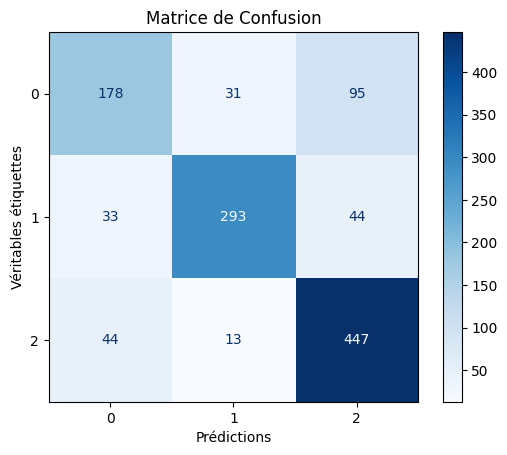

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import matplotlib
# matplotlib.use('qtagg')  # Alternatively, you could try 'TkAgg' or 'Qt5Agg' if 'Agg' doesn't work
import matplotlib.pyplot as plt

# Chemins
base_folder_black = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_black'
base_folder_rgb = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5\Images_rgb'
save_folder = r'C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_5'
csv_path = os.path.join(save_folder, 'model_performances.csv')
best_model_save_path="C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Projet_5/best_model_RGB.keras"
img_size = 255
num_classes = 3
dog_races = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
# Préparer les générateurs d'images
def prepare_data_generators(batch_size, is_black_and_white=True):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    color_mode = 'grayscale' if is_black_and_white else 'rgb'
    
    train_generator = datagen.flow_from_directory(
        base_folder_black if is_black_and_white else base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        base_folder_black if is_black_and_white else base_folder_rgb,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        classes=dog_races,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, val_generator


train_generator_rgb, val_generator_rgb = prepare_data_generators(batch_size=8, is_black_and_white=False)

# Obtenir les prédictions et les vraies étiquettes pour les données de validation
# Nous faisons des prédictions en mode batch pour éviter de surcharger la mémoire
y_true = []
y_pred = []
model=load_model(best_model_save_path)
# Parcourir les batchs du générateur de validation
for batch in val_generator_rgb:
    images, labels = batch  # Récupérer les images et les labels du batch
    predictions = model.predict(images,verbose=0)  # Prédire les labels pour les images du batch

    y_true.extend(np.argmax(labels, axis=1))  # Ajouter les labels réels (argmax pour convertir one-hot en indices)
    y_pred.extend(np.argmax(predictions, axis=1))  # Ajouter les prédictions (argmax pour convertir probabilités en indices)

    # Arrêter la boucle une fois toutes les données de validation traitées
    if len(y_true) >= val_generator_rgb.samples:
        break

# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion de manière visuelle
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

## Courbes de perte et de précision pour le meilleur modèle - set d'netraînement et de validation

Found 4712 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\pdevi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


589/589 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - accuracy: 0.4308 - loss: 1.0307 - val_accuracy: 0.5747 - val_loss: 0.9202
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - accuracy: 0.6394 - loss: 0.8314 - val_accuracy: 0.6706 - val_loss: 0.7639
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.6937 - loss: 0.7060 - val_accuracy: 0.6817 - val_loss: 0.7436
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.7577 - loss: 0.5927 - val_accuracy: 0.7199 - val_loss: 0.6587
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - accuracy: 0.8074 - loss: 0.4901 - val_accuracy: 0.7479 - val_loss: 0.6007
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.8413 - loss: 0.4072 - val_accuracy: 0.7623 - val_loss: 0.6015
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - accuracy: 0.8678 - loss: 0.3579 - val_accuracy: 0.7334 - val_loss: 0.7006
Epoch 8/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.8995 - loss: 0.2902 - val_accurac

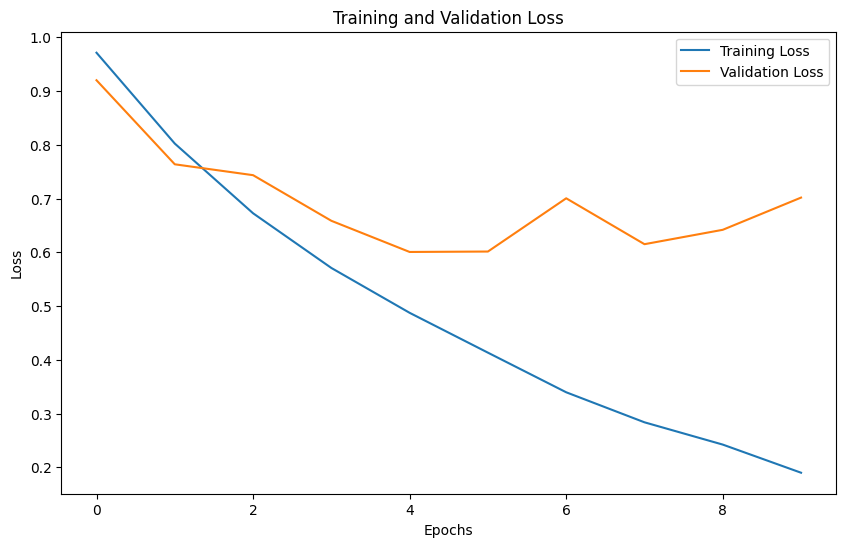

In [5]:
# Importer les bibliothèques nécessaires
import matplotlib.pyplot as plt

# Définir les meilleurs paramètres trouvés par la recherche de grille
best_params = {
    'batch_size': 8,
    'optimizer': 'adam',
    'learning_rate': 0.0001,
    'epochs': 20
}

# Fonction pour créer un modèle Conv2D
def create_conv2d_model(input_shape, optimizer):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compiler le modèle avec l'optimiseur et la fonction de perte spécifiés
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer les générateurs de données avec le meilleur batch size
train_generator_rgb, val_generator_rgb = prepare_data_generators(batch_size=best_params['batch_size'], is_black_and_white=False)

# Définir l'optimiseur avec le taux d'apprentissage spécifié
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])

# Définir le modèle en utilisant les meilleurs paramètres
model = create_conv2d_model(input_shape=(img_size, img_size, 3), optimizer=optimizer)

# Définir le callback pour un arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculer les poids de classe pour gérer le déséquilibre des classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator_rgb.classes), y=train_generator_rgb.classes)
class_weights_dict = dict(enumerate(class_weights))

# Réentraîner le modèle avec les paramètres spécifiés
history = model.fit(
    train_generator_rgb,
    validation_data=val_generator_rgb,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Tracer les courbes de perte pour l'entraînement et la validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
